In [1]:
%autosave 60

Autosaving every 60 seconds


# NYC dataset

# Basics

## Import Libraries

In [235]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
from pandas_profiling import ProfileReport

## For geomap purpose
import geopandas
import folium

## For checking missing values
import missingno as msno

## For test/train splititng
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

In [236]:
#! python3 -m pip install --user xgboost

## upload dataset

In [237]:
def get_dataset(local_dir_name):
    '''
    param local_dir_name: name of the directory to which the dataset belongs to
    
    assume that variable 'DirForLocalDataset' is set systemwide 
    Returns pandas dataframe
    '''
    path_dataset = os.getenv("DirForLocalDataset") + '/'+ local_dir_name
    
    df = pd.read_csv(os.path.join(path_dataset, os.listdir(path_dataset)[1]))
    return df

In [238]:
df_bike  = get_dataset('axa_dataset')
df_bike.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,16649,Subscriber,1984.0,1


# insight into data

In [239]:
print(f"Shape of dataset is {df_bike.shape}")
print(df_bike.dtypes)

Shape of dataset is (577703, 15)
tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id             float64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                 float64
gender                       int64
dtype: object


In [240]:
df_bike.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,5.777030e+05,577703.000000,577703.000000,577703.000000,559644.000000,559644.000000,559644.000000,577703.000000,337382.000000,577703.000000
mean,1.372570e+03,439.228836,40.732436,-73.991251,441.910624,40.732146,-73.991244,17617.434516,1974.644945,0.710431
std,9.028063e+03,337.240318,0.021423,0.013002,345.448311,0.021507,0.013105,1677.518719,10.780255,0.678268
min,6.100000e+01,72.000000,40.646607,-74.017134,72.000000,40.646607,-74.017134,14529.000000,1899.000000,0.000000
25%,5.140000e+02,309.000000,40.717400,-74.001768,309.000000,40.716887,-74.001971,16161.000000,1968.000000,0.000000
50%,8.740000e+02,404.000000,40.734546,-73.990741,403.000000,40.734232,-73.990741,17638.000000,1977.000000,1.000000
75%,1.398000e+03,482.000000,40.749013,-73.981948,482.000000,40.748549,-73.981923,19066.000000,1983.000000,1.000000
max,3.876479e+06,3020.000000,40.771522,-73.950048,3020.000000,40.771522,-73.950048,20625.000000,1997.000000,2.000000


## Profiling

In [241]:
profile = ProfileReport(df_bike, title="Pandas Profiling Report")
#profile

## Quick Statistics

In [242]:
def draw_stats(df, n_rows=10, n_cols=2):
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,25))

    i = 1
    for col in df.columns:
        if df[col].dtype == np.float64 or df[col].dtype == np.int64:
            ax = plt.subplot(n_rows, n_cols, i)
            df[col].hist(bins=30)
            ax.set_title(col)
            i += 1
            ax = plt.subplot(n_rows, n_cols, i)
            df[col].hist(bins=30)
            ax.set_title(col+" (log scale)")
            ax.set_yscale('log')
            i += 1

    fig.tight_layout()
    plt.show()

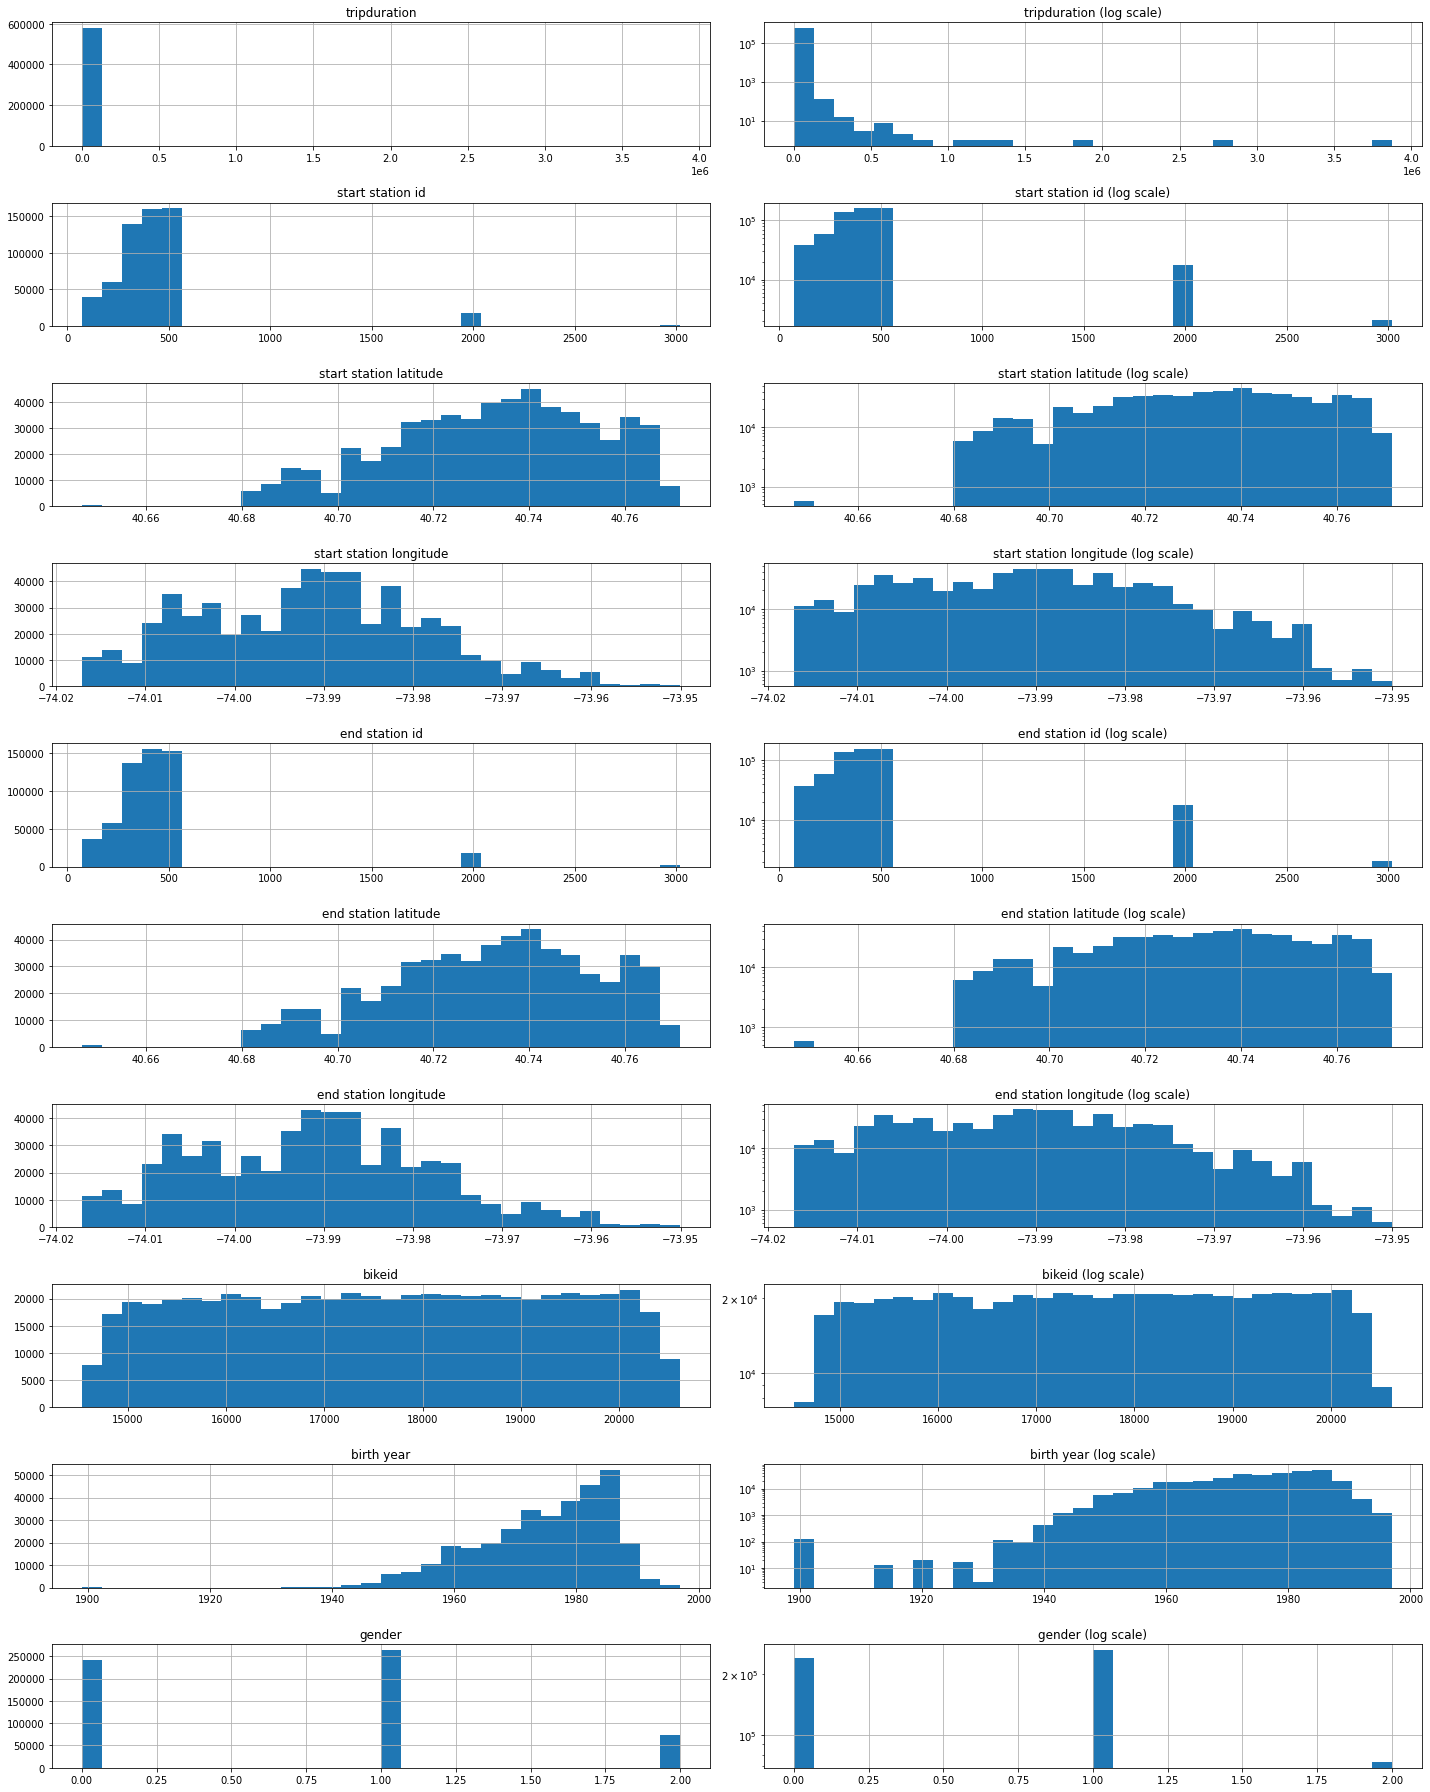

In [243]:
draw_stats(df_bike)

Observations:
1. few D.O.B are dated 1990, ie. 122 years old.
2. trip durations got maximum of around 4e6

## Check coorrelation

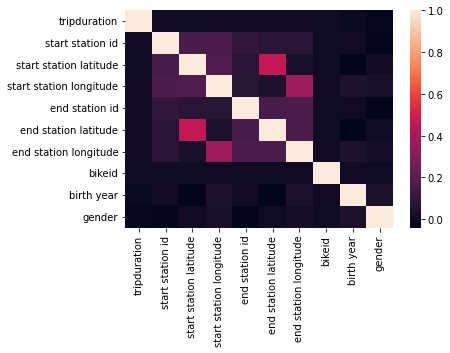

In [244]:
corr = df_bike.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

plt.savefig('heatmap_coorelation_plot.png')

# Preprocessing
1. lets first take care of the 2 variable, tripduration and D.O.B cases.

## Tripduration

### Tripduration in min/hrs

In [245]:
df_bike['duration_mins'] = df_bike['tripduration']/60
df_bike['duration_hr']   = df_bike['tripduration']/(60*60)

In [246]:
print(df_bike['duration_hr'].describe())

count    577703.000000
mean          0.381270
std           2.507795
min           0.016944
25%           0.142778
50%           0.242778
75%           0.388333
max        1076.799722
Name: duration_hr, dtype: float64


### Tripduration in hr
1. The maximum is 1076 hrs, that's around 44 days.
2. Another important aspect is that there are 25% value between (0.38, 1076) hrs, in which, thankfully, the lower bound still is quite reasonable.
3. my understanding says 24 hr, ie. whole day, is quite an extreme value for renting bike.

In [247]:
print("count is:", df_bike['duration_hr'][df_bike['duration_hr']>24].count())

count is: 344


Text(0, 0.5, 'Count')

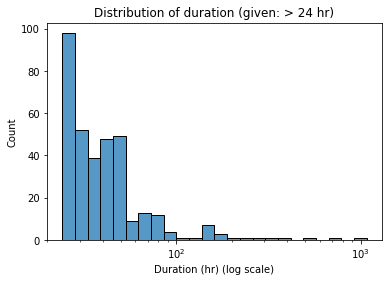

In [248]:
sns.histplot(x=df_bike['duration_hr'][df_bike['duration_hr']>24], log_scale=True)
plt.title("Distribution of duration (given: > 24 hr)")
plt.xlabel("Duration (hr) (log scale)")
plt.ylabel('Count')

### Lets drop 344 evens of tripduration(hr) > 24

In [249]:
print(f"shape of original: {df_bike.shape}, after filtering dataset: {df_bike[df_bike['duration_hr'] < 24].shape}")
df_bike = df_bike[df_bike['duration_hr'] < 24]

shape of original: (577703, 17), after filtering dataset: (577359, 17)


## Users

### Calculate age of the users

Text(0, 0.5, 'Count')

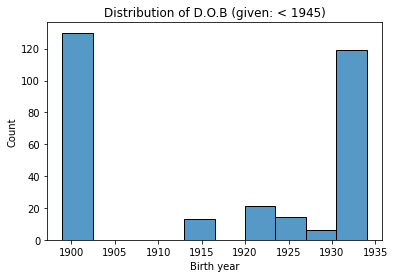

In [250]:
sns.histplot(x=df_bike['birth year'][df_bike['birth year'] < 1935])
plt.title("Distribution of D.O.B (given: < 1945)")
plt.xlabel("Birth year")
plt.ylabel('Count')

In [251]:
df_bike['age'] = (pd.DatetimeIndex(df_bike['starttime']).year - df_bike['birth year'])
df_bike.head(3)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,duration_mins,duration_hr,age
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,19678,Subscriber,1983.0,1,11.583333,0.193056,30.0
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,16649,Subscriber,1984.0,1,11.550000,0.192500,29.0
2,2059,2013-06-01 00:00:44,2013-06-01 00:35:03,406,Hicks St & Montague St,40.695128,-73.995951,406.0,Hicks St & Montague St,40.695128,-73.995951,19599,Customer,NaN,0,34.316667,0.571944,NaN


Text(0.5, 0, 'Age')

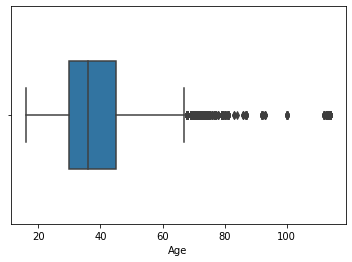

In [252]:
#sns.set_theme(style="whitegrid")
sns.boxplot(x=df_bike["age"], width=0.5)
plt.xlabel("Age")

In [253]:
skip = (df_bike.loc[:, ('age')] > 78)
df_bike['age'] = df_bike['age'].mask(skip,None)

Text(0, 0.5, 'Count')

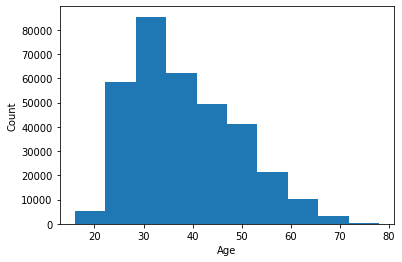

In [254]:
plt.hist(df_bike['age'])
#plt.title("Distribution of Usertype during Weekday")
plt.xlabel("Age")
plt.ylabel('Count')

### Convert gender as string categorical

In [255]:
df_bike.groupby('gender').size()

gender
0    240597
1    263335
2     73427
dtype: int64

(array([263335.,      0.,      0.,      0.,      0., 240597.,      0.,
             0.,      0.,  73427.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

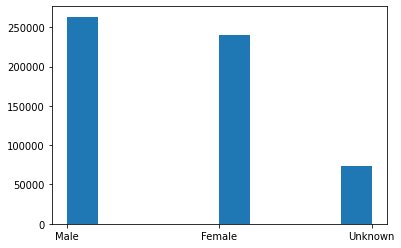

In [256]:
gender_int = [1, 0, 2]
gender_str = ['Male','Female','Unknown']
df_bike['gender']= df_bike['gender'].replace(gender_int, gender_str)
df_bike["gender"] = df_bike["gender"].astype("category")
plt.hist(df_bike['gender'])

## Time

### Convert timestamp to datetime variable

In [257]:
df_bike["starttime"] = pd.to_datetime(df_bike['starttime'], format='%Y-%m-%d %H:%M:%S') 
df_bike["stoptime"]  = pd.to_datetime(df_bike['stoptime'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
df_bike['starttime'].dt.date

### Calculate Month/time/weekday from timetamp

In [367]:
df_bike['month']= df_bike['starttime'].dt.month_name()
df_bike['time'] =  df_bike['starttime'].dt.time
df_bike['weekday'] = df_bike['starttime'].dt.day_name()
df_bike['hour'] = df_bike['starttime'].dt.hour
df_bike['date'] = df_bike['starttime'].dt.date

In [259]:
from pandas.api.types import CategoricalDtype
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

cat_type = CategoricalDtype(categories=cats, ordered=True)
df_bike['weekday_cat'] = df_bike['weekday'].astype(cat_type)

In [260]:
df_bike.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,birth year,gender,duration_mins,duration_hr,age,month_name,time,weekday,hour,weekday_cat
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,...,1983.0,Male,11.583333,0.193056,30.0,June,00:00:01,Saturday,0,Saturday
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,...,1984.0,Male,11.550000,0.192500,29.0,June,00:00:08,Saturday,0,Saturday


### Which year/month the dataset belongs to?

In [261]:
def get_label_size_list(df, column):
    '''
    param df: pandas dataset
    param column : column as string
    
    Usage: useful for ploting pie plot, since returns label and frequency list of the given column
    Eg: returns: (['June', 'July'], [559643, 1])
    '''
    label_list= []
    size_list = []
    
    value_list = df[column].unique()
    [label_list.append(val) for val in value_list]
    [size_list.append(df[df[column]==val][column].count()) for val in value_list]
    
    return label_list, size_list

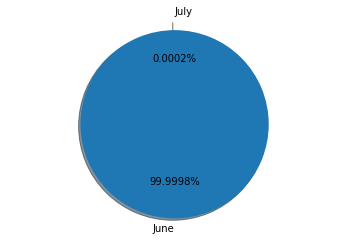

In [264]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = get_label_size_list(df_bike, 'month')[0]
sizes = get_label_size_list(df_bike, 'month')[1]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%3.4f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [265]:
df_bike['month'].value_counts()

June    577358
July         1
Name: month, dtype: int64

## Geo Info

### Calculate distance between start/end

In [266]:
def get_distance(lat1, lon1, lat2, lon2):
    earth_radius=6371
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))    

In [267]:
df_bike['dist_km'] = get_distance(df_bike["start station latitude"], df_bike["start station longitude"], 
                                    df_bike["end station latitude"], df_bike["end station longitude"])

### Station information

In [268]:
print(df_bike['start station id'].unique().shape)

(337,)


## Missing values

In [269]:
df_bike.isnull().sum() * 100 / len(df_bike)

tripduration                0.000000
starttime                   0.000000
stoptime                    0.000000
start station id            0.000000
start station name          0.000000
start station latitude      0.000000
start station longitude     0.000000
end station id              3.124919
end station name            3.124919
end station latitude        3.124919
end station longitude       3.124919
bikeid                      0.000000
usertype                    0.000000
birth year                 41.598555
gender                      0.000000
duration_mins               0.000000
duration_hr                 0.000000
age                        41.651035
month_name                  0.000000
time                        0.000000
weekday                     0.000000
hour                        0.000000
weekday_cat                 0.000000
month                       0.000000
dist_km                     3.124919
dtype: float64

<AxesSubplot:>

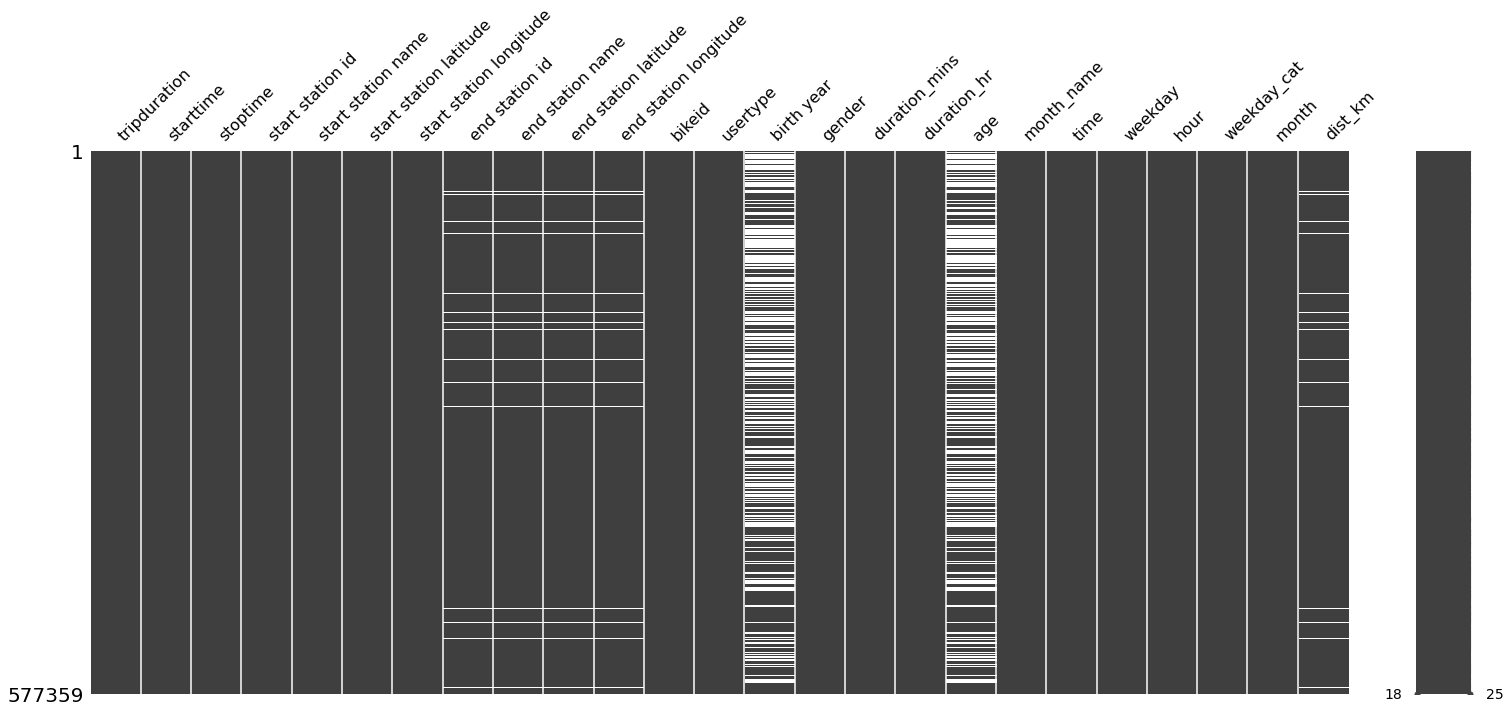

In [270]:
msno.matrix(df_bike)

<AxesSubplot:>

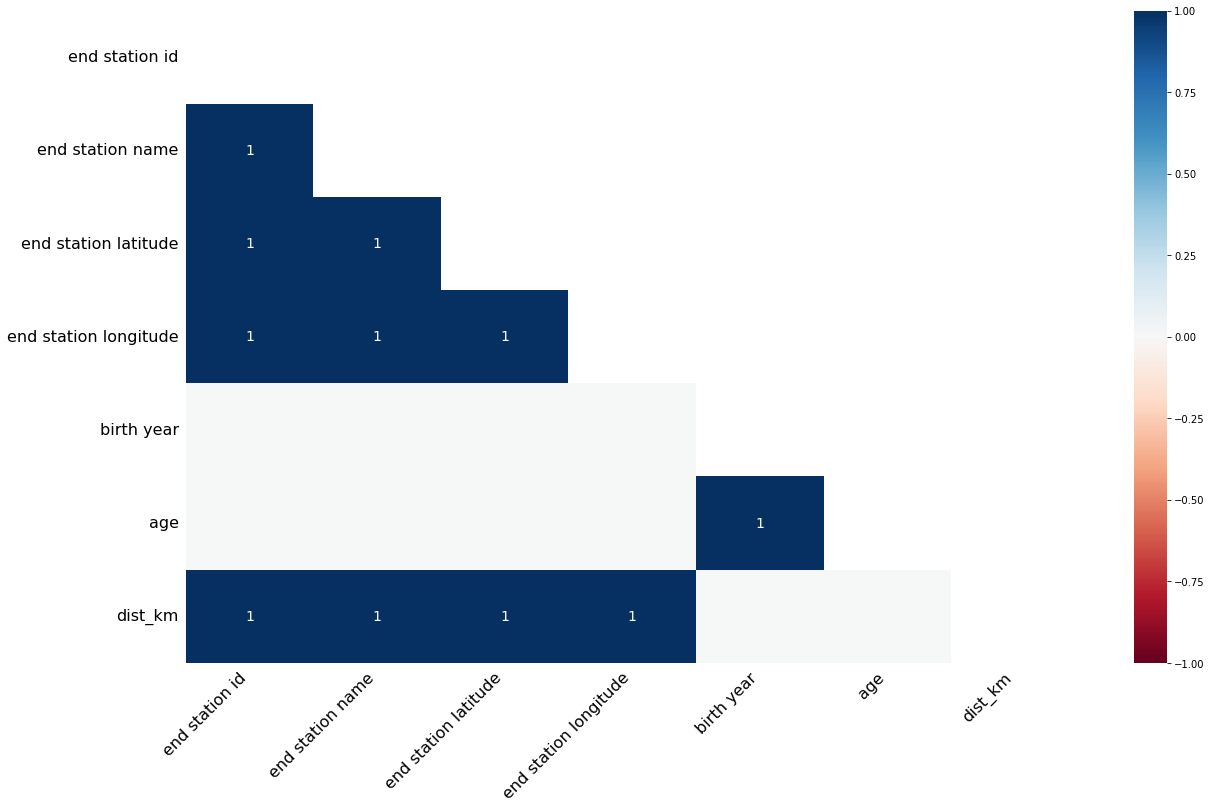

In [271]:
msno.heatmap(df_bike)

In [272]:
df_bike=df_bike.dropna(subset=['end station name']) #3% of data

In [273]:
df_bike.isnull().sum() * 100 / len(df_bike)

tripduration                0.000000
starttime                   0.000000
stoptime                    0.000000
start station id            0.000000
start station name          0.000000
start station latitude      0.000000
start station longitude     0.000000
end station id              0.000000
end station name            0.000000
end station latitude        0.000000
end station longitude       0.000000
bikeid                      0.000000
usertype                    0.000000
birth year                 41.596983
gender                      0.000000
duration_mins               0.000000
duration_hr                 0.000000
age                        41.649726
month_name                  0.000000
time                        0.000000
weekday                     0.000000
hour                        0.000000
weekday_cat                 0.000000
month                       0.000000
dist_km                     0.000000
dtype: float64

In [274]:
## Lets define a varaible dob_missing to filter out the values
df_bike['dob_missing'] = df_bike['birth year'].isnull()
#df_bike['dob_missing'] = np.where(df_bike['birth year'].isnull(), True, False)
df_bike.head(4)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,duration_hr,age,month_name,time,weekday,hour,weekday_cat,month,dist_km,dob_missing
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,...,0.193056,30.0,June,00:00:01,Saturday,0,Saturday,June,1.226123,False
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,...,0.192500,29.0,June,00:00:08,Saturday,0,Saturday,June,1.226123,False
2,2059,2013-06-01 00:00:44,2013-06-01 00:35:03,406,Hicks St & Montague St,40.695128,-73.995951,406.0,Hicks St & Montague St,40.695128,...,0.571944,NaN,June,00:00:44,Saturday,0,Saturday,June,0.000000,True
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,E 15 St & Irving Pl,40.735243,-73.987586,262.0,Washington Park,40.691782,...,0.034167,53.0,June,00:01:04,Saturday,0,Saturday,June,4.971683,False


In [275]:
df_bike[df_bike["dob_missing"]==True].groupby("gender")["dob_missing"].count()

gender
Female     232657
Male            2
Unknown         0
Name: dob_missing, dtype: int64

In [276]:
df_bike[df_bike["dob_missing"]==True].groupby("usertype")["tripduration"].count()

usertype
Customer      232657
Subscriber         2
Name: tripduration, dtype: int64

In [277]:
df_bike[df_bike["dob_missing"]==True].groupby("usertype").groups

{'Customer': [2, 5, 11, 13, 17, 18, 19, 27, 35, 37, 46, 47, 54, 58, 63, 67, 68, 69, 75, 76, 81, 83, 86, 90, 95, 97, 99, 103, 112, 113, 116, 118, 130, 139, 141, 142, 153, 154, 157, 169, 171, 172, 174, 177, 178, 185, 186, 195, 197, 203, 204, 205, 206, 216, 217, 221, 226, 229, 230, 234, 237, 244, 246, 247, 248, 254, 257, 259, 261, 262, 268, 269, 272, 273, 274, 277, 284, 285, 286, 288, 295, 298, 301, 303, 305, 306, 314, 317, 318, 323, 324, 333, 335, 340, 342, 344, 345, 347, 348, 349, ...], 'Subscriber': [550443, 551263]}

In [278]:
df_bike[df_bike["dob_missing"]==True].groupby("usertype").get_group('Subscriber')['tripduration'].count()

2

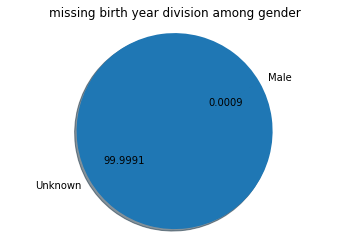

In [279]:
fig1, ax1 = plt.subplots()
ax1.pie([232801,2],labels=["Unknown", "Male"], autopct='%.4f',
        shadow=True, startangle=30)
ax1.axis('equal')  
plt.title('missing birth year division among gender')

plt.show()

Observation
1. All users with DOB-missing are of unknown gender and are customers.
2. To take care of this missing-values, since it is highly correlated to usertype and gender, lets define another catogorical variable for age, taking care of this missing values at seperate category.

### Define age_range variable to take care of the missing D.O.B

In [280]:
bins = [20,         30,     40,      50,      60,      70,     80,  90]
names = ['25-30', '30-40', '40-50', '50-60', '60-70', '70-80', '100+']
df_bike['age_range'] = pd.cut(df_bike['age'], bins, labels=names)
df_bike['age_range']=df_bike['age_range'].fillna("100+") 

Text(0, 0.5, 'Count')

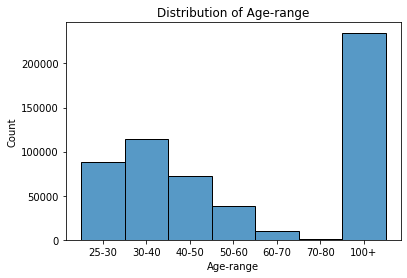

In [281]:
sns.histplot(df_bike['age_range'])
plt.title("Distribution of Age-range")
plt.xlabel("Age-range")
plt.ylabel('Count')

In [282]:
## Lets drop DOB column
df_bike=df_bike.drop(["birth year"], axis=1)


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,age,month_name,time,weekday,hour,weekday_cat,month,dist_km,dob_missing,age_range
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,...,30.0,June,00:00:01,Saturday,0,Saturday,June,1.226123,False,25-30
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,...,29.0,June,00:00:08,Saturday,0,Saturday,June,1.226123,False,25-30


In [81]:
df_bike.isnull().sum() * 100 / len(df_bike)

tripduration                0.000000
starttime                   0.000000
stoptime                    0.000000
start station id            0.000000
start station name          0.000000
start station latitude      0.000000
start station longitude     0.000000
end station id              0.000000
end station name            0.000000
end station latitude        0.000000
end station longitude       0.000000
bikeid                      0.000000
usertype                    0.000000
gender                      0.000000
duration_mins               0.000000
duration_hr                 0.000000
age                        41.649726
month                       0.000000
time                        0.000000
weekday                     0.000000
dist_km                     0.000000
dob_missing                 0.000000
age_range                   0.000000
dtype: float64

<AxesSubplot:ylabel='usertype'>

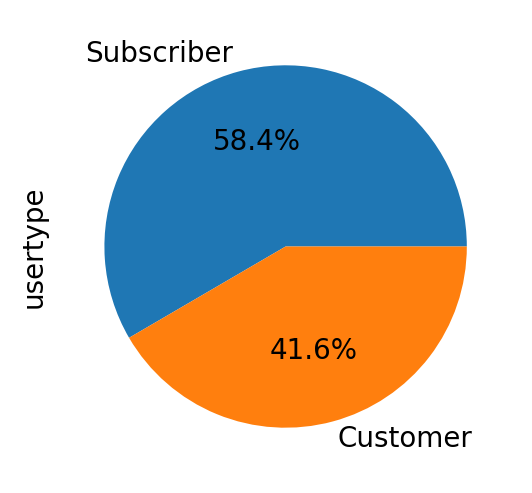

In [286]:
fig = plt.figure(figsize=(3,3), dpi=200)
ax = plt.subplot(111)
df_bike['usertype'].value_counts().plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=0, fontsize=10)

# Explanatory Analysis

### frequency of user's gender?

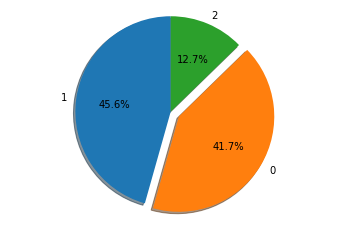

<Figure size 432x288 with 0 Axes>

In [82]:
# Pie chart
labels = get_label_size_list(df_bike, 'gender')[0]
sizes =  get_label_size_list(df_bike, 'gender')[1]
explode = (0, 0.1,0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()
plt.savefig('piedist_gender.png')

###  How users are distributed during Weekdays?

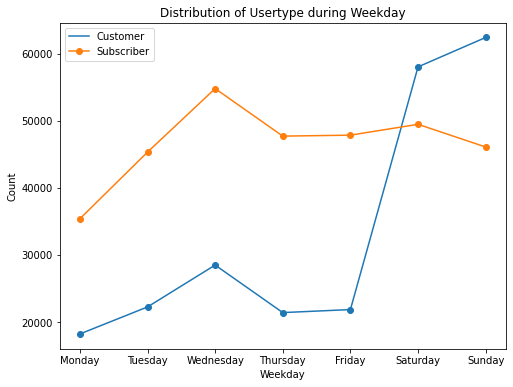

In [83]:
fig, ax = plt.subplots(figsize=(8,6))

df_bike[df_bike['usertype']=="Customer"].groupby("weekday")["usertype"].count().plot(ax=ax, label='Customer', marker='o',legend=True)
df_bike[df_bike['usertype']=="Subscriber"].groupby("weekday")["usertype"].count().plot(ax=ax, label='Subscriber', marker='o', legend=True)
plt.title("Distribution of Usertype during Weekday")
plt.xlabel("Weekday")
plt.ylabel('Count')
plt.savefig("usertype_during_weekday.png")

###  Age vs Weekday Distribution

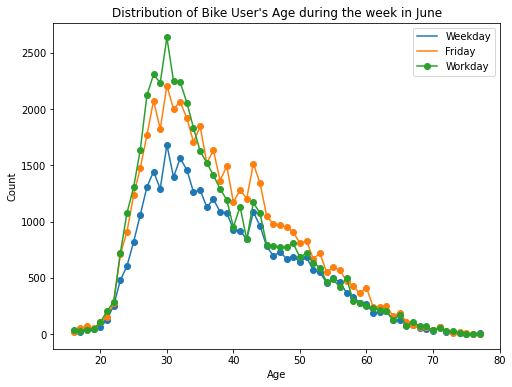

In [50]:
fig, ax = plt.subplots(figsize=(8,6))
weekday = ("Monday" or "Tuesday" or "Wednesday" or "Thursday")
df_bike[df_bike['weekday']==weekday].groupby("age")["weekday"].count().plot(ax=ax, label='Weekday', marker='o',legend=True)
df_bike[df_bike['weekday']=="Friday"].groupby("age")["weekday"].count().plot(ax=ax, label='Friday', marker='o',legend=True)
df_bike[df_bike['weekday'] == ("Sunday" or "Saturday")].groupby("age")["weekday"].count().plot(ax=ax, label='Workday', marker='o',legend=True)


plt.title("Distribution of Bike User's Age during the week in June")
plt.xlabel("Age")
plt.ylabel('Count')
plt.savefig("agedist_during_week.png")

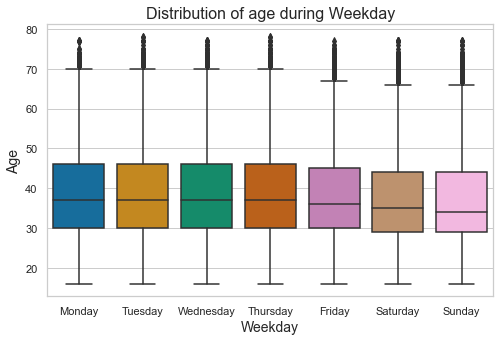

In [51]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set_theme(style="whitegrid")
bplot=sns.boxplot(x="weekday", y="age", palette="colorblind", data=df_bike)
bplot.axes.set_title("Distribution of age during Weekday", fontsize=16)
bplot.set_ylabel("Age", fontsize=14)
bplot.set_xlabel("Weekday", fontsize=14)
plt.savefig('age_weekday_boxplot.png')

### How many Unique bikes are avaialble?

number of unique bike-id is:  (5793,)


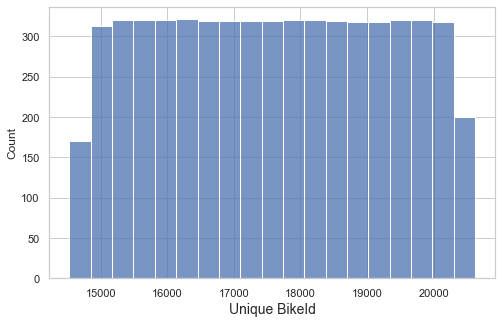

In [52]:
bplot=sns.histplot(df_bike["bikeid"].unique())
bplot.set_xlabel("Unique BikeId", fontsize=14)
plt.savefig("Unique_bikes.png")
print("number of unique bike-id is: ", df_bike["bikeid"].unique().shape)

### Distribution of Users age vs gender

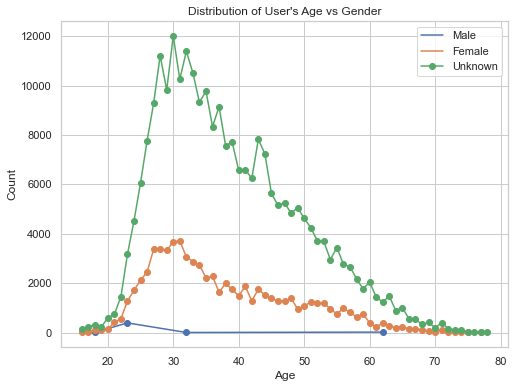

In [53]:
fig, ax = plt.subplots(figsize=(8,6))

df_bike[df_bike['gender']=="Male"].groupby("age")["age"].count().plot(ax=ax, label='Male', marker='o',legend=True)
df_bike[df_bike['gender']=="Female"].groupby("age")["age"].count().plot(ax=ax, label='Female', marker='o',legend=True)
df_bike[df_bike['gender']=="Unknown"].groupby("age")["age"].count().plot(ax=ax, label='Unknown', marker='o',legend=True)


plt.title("Distribution of User's Age vs Gender")
plt.xlabel("Age")
plt.ylabel('Count')
plt.savefig("age_vs_gender.png")

### Trip vs User gender 

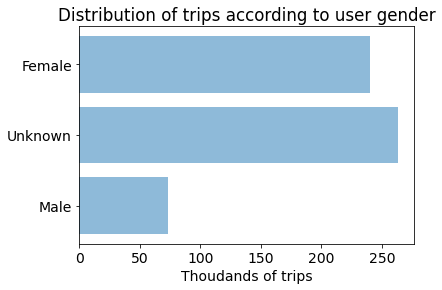

In [26]:
trip_counts = df_bike.groupby('gender')['gender'].count()
plt.rcParams.update({'font.size': 14})
plt.barh([0, 1, 2], trip_counts / 1000, align = 'center', alpha = 0.5)
plt.yticks([0, 1, 2], gender_str)
plt.xlabel('Thoudands of trips')
plt.title('Distribution of trips according to user gender')
plt.show()

### Distribution of trip duration

Text(0, 0.5, 'Trip counts')

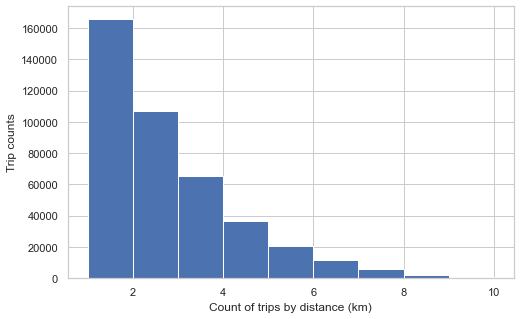

In [55]:
plt.rcParams.update({'font.size': 14})
bins_list = [1,2,3,4 ,5,6,7,8,9, 10] 
plt.hist(df_bike['dist_km'][(df_bike['dist_km'] < 10) & (df_bike['dist_km'] != 0 )], bins=bins_list )
#plt.tick_params(axis = 'both', which = 'major')
#plt.title('Distribution of trip durations\n')
plt.xlabel('Count of trips by distance (km)')
plt.ylabel('Trip counts')

In [56]:
df_bike['duration_mins'].describe() ## (mean, sd) : (22, 151) minuetes 

count    559317.000000
mean         20.990884
std          47.406340
min           1.016667
25%           8.566667
50%          14.550000
75%          23.283333
max        1437.733333
Name: duration_mins, dtype: float64

Text(0, 0.5, 'Trip counts')

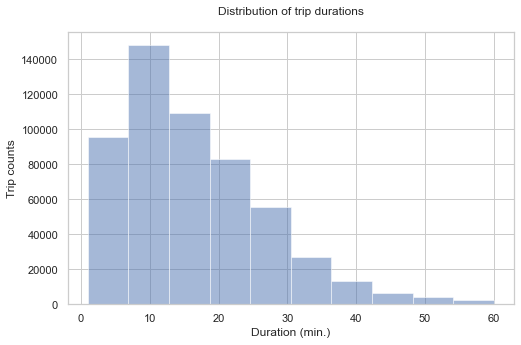

In [57]:
# Plot the distribution of trip durations
plt.rcParams.update({'font.size': 14})
df_bike['duration_mins'][(df_bike['duration_mins']< 60) & (df_bike['duration_mins'] !=0)].hist(figsize = (8,5), bins = 10, alpha = 0.5)
plt.title('Distribution of trip durations\n')
plt.xlabel('Duration (min.)')
plt.ylabel('Trip counts')

## Frequency of trips per day per hour

In [357]:
df_1 = df_bike[df_bike["start station name"] == "Central Park S & 6 Ave"]
df_1 = df_1.loc[:, ['tripduration', 'starttime']] 
df_1.index = df_1['starttime']

In [358]:
june1_sat  = df_1[df_1.index.date == pd.Timestamp(2013, 6, 1)]
june2_sun  = df_1[df_1.index.date == pd.Timestamp(2013, 6, 2)]
june3_mon  = df_1[df_1.index.date == pd.Timestamp(2013, 6, 3)]

june1_countsPerHr  = june1_sat.groupby(june1_sat.index.hour).size()
june2_countsPerHr  = june2_sun.groupby(june2_sun.index.hour).size()
june3_countsPerHr  = june3_mon.groupby(june3_mon.index.hour).size()

/var/folders/6n/xskqb5954jsfxw29ddrrqp74tqq6_x/T/ipykernel_90280/3964430227.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  june1_sat  = df_1[df_1.index.date == pd.Timestamp(2013, 6, 1)]
/var/folders/6n/xskqb5954jsfxw29ddrrqp74tqq6_x/T/ipykernel_90280/3964430227.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  june2_sun  = df_1[df_1.index.date == pd.Timestamp(2013, 6, 2)]
/var/folders/6n/xskqb5954jsfxw29ddrrqp74tqq6_x/T/ipykernel_90280/3964430227.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future 

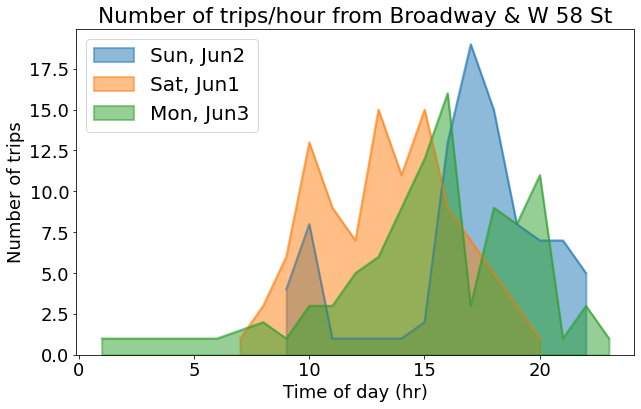

In [360]:
plt.rcParams.update({'font.size': 18, 'legend.fontsize': 20})
june2_countsPerHr.plot(kind = 'area', stacked = False, 
                          linewidth = 2, label='Sun, Jun2', legend=True,figsize = (10, 6))
june1_countsPerHr.plot(kind = 'area', stacked = False, 
                          linewidth = 2, label='Sat, Jun1', legend=True)
june3_countsPerHr.plot(kind = 'area', stacked = False, 
                          linewidth = 2, label='Mon, Jun3', legend=True)

plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
#ax = plt.gca()
plt.title('Number of trips/hour from Broadway & W 58 St')
plt.xlabel('Time of day (hr)')
plt.ylabel('Number of trips')
legend = ax.legend(loc='upper left', frameon = False)

In [216]:
# Calculate trip counts per hour on weekdays and weekends
df_sub = df_bike.loc[:, ['tripduration', 'starttime']] 
df_sub.index = df_sub['starttime']
monday  = df_sub[df_sub.index.date == 0]
tuesday = df_sub[df_sub.index.weekday == 1]
wednesday = df_sub[df_sub.index.weekday == 2]
monday_countsPerHr  = monday.groupby(monday.index.hour).size()
tuesday_countsPerHr = tuesday.groupby(tuesday.index.hour).size()
wednesday_countsPerHr = wednesday.groupby(wednesday.index.hour).size()

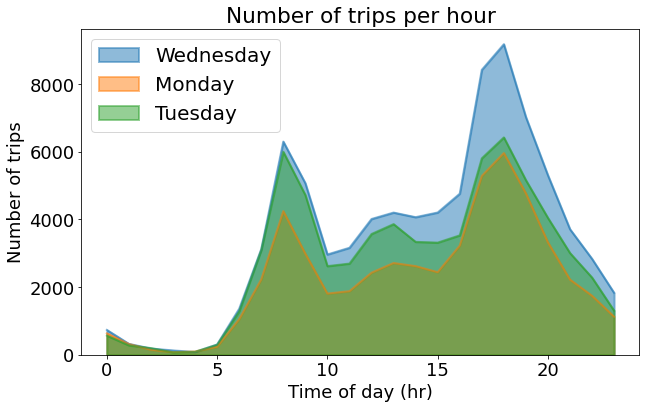

In [194]:
plt.rcParams.update({'font.size': 18, 'legend.fontsize': 20})
wednesday_countsPerHr.plot(kind = 'area', stacked = False, 
                          linewidth = 2, label='Wednesday', legend=True)

monday_countsPerHr.plot(kind = 'area', stacked = False, figsize = (10, 6),
                          linewidth = 2, label='Monday', legend=True)

tuesday_countsPerHr.plot(kind = 'area', stacked = False, 
                          linewidth = 2, label='Tuesday', legend=True)


plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
#ax = plt.gca()
plt.title('Number of trips per hour')
plt.xlabel('Time of day (hr)')
plt.ylabel('Number of trips')
legend = ax.legend(loc='upper left', frameon = False)

### Frequency of trips per hrs

In [58]:
# Calculate trip counts per hour on weekdays and weekends
df_sub = df_bike.loc[:, ['tripduration', 'starttime']] 
df_sub.index = df_sub['starttime']
weekdays = df_sub[df_sub.index.weekday < 5]
weekends = df_sub[df_sub.index.weekday > 4]
weekdays_countsPerHr = weekdays.groupby(weekdays.index.hour).size()
weekends_countsPerHr = weekends.groupby(weekends.index.hour).size()

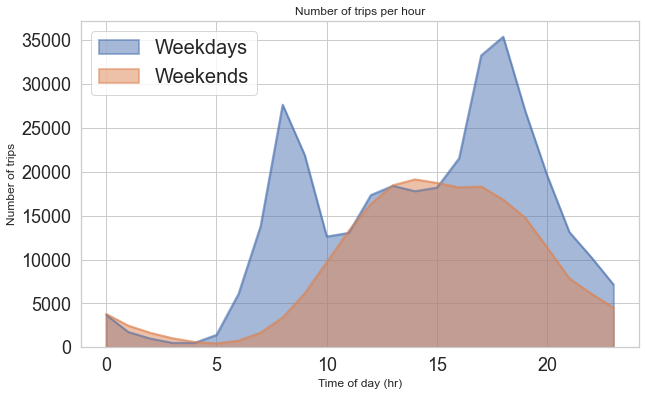

In [59]:
plt.rcParams.update({'font.size': 18, 'legend.fontsize': 20})
weekdays_countsPerHr.plot(kind = 'area', stacked = False, figsize = (10, 6),
                          linewidth = 2, label='Weekdays', legend=True)

weekends_countsPerHr.plot(kind = 'area', stacked = False, 
                          linewidth = 2, label='Weekends', legend=True)

plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
#ax = plt.gca()
plt.title('Number of trips per hour')
plt.xlabel('Time of day (hr)')
plt.ylabel('Number of trips')
legend = ax.legend(loc='upper left', frameon = False)

### Frequency of trips per day

In [361]:
df_1 = df_bike[(df_bike["start station name"] == "Central Park S & 6 Ave") & 
              (df_bike.index.date == pd.Timestamp(2013, 6, 1)]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,age,month_name,time,weekday,hour,weekday_cat,month,dist_km,dob_missing,age_range
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,...,30.0,June,00:00:01,Saturday,0,Saturday,June,1.226123,False,25-30


In [182]:
df_bike.index = df_bike['starttime']
countsPerDay = df_bike.starttime.resample('D').agg('count')

Text(0, 0.5, 'Number of trips')

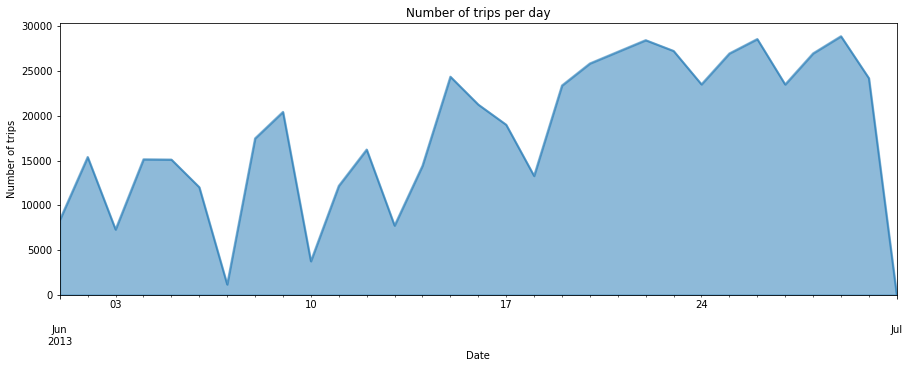

In [183]:
countsPerDay.plot(kind = 'area', stacked = False, figsize = (15, 5), linewidth = 2)
#plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.title('Number of trips per day')
plt.xlabel('Date')
plt.ylabel('Number of trips')

### Which station had the oldest riders on average

In [457]:
n_trip=10 #1258
cut = df_bike[df_bike['age']>60].groupby(['start station name', 'end station name']).filter(lambda x: x['tripduration'].count() >= n_trip) 

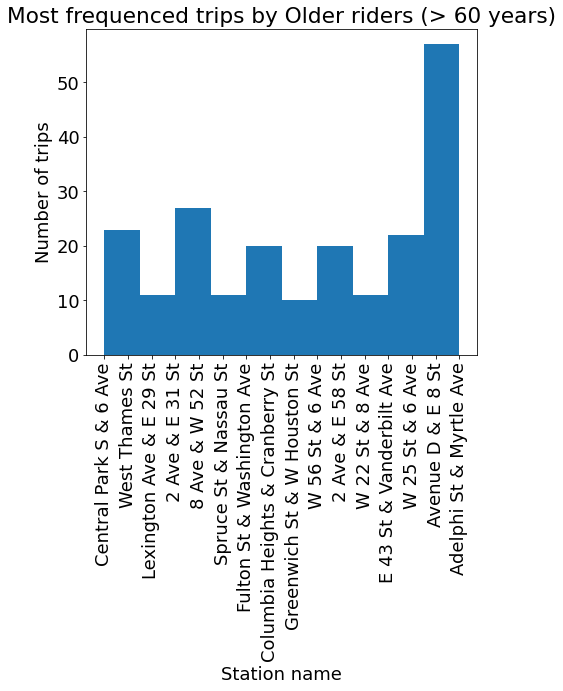

In [461]:
fig, ax = plt.subplots(figsize=(7,6))
plt.hist(cut['start station name'])
plt.xticks(rotation='vertical')
#plt.xticks(rotation=45)
plt.title('Most frequenced trips by Older riders (> 60 years)')
plt.xlabel('Station name')
plt.ylabel('Number of trips')
plt.show()

### Most Populer Customer Trip

In [444]:
n_trip=200 #1258
cut=df_bike[df_bike['usertype']=='Customer'].groupby(['start station name', 'end station name']).filter(lambda x: x['tripduration'].count() >= n_trip) 

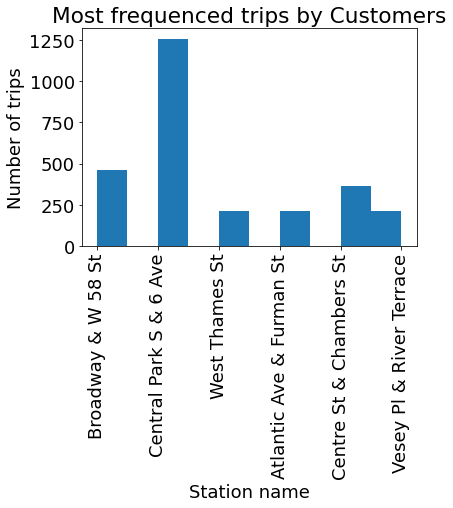

In [445]:
plt.hist(cut['start station name'])
plt.xticks(rotation='vertical')
#plt.xticks(rotation=45)
plt.title('Most frequenced trips by Customers')
plt.xlabel('Station name')
plt.ylabel('Number of trips')
plt.show()

(array([2.661e+03, 4.500e+01, 6.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.77777778e-02, 2.34325000e+00, 4.66872222e+00, 6.99419444e+00,
        9.31966667e+00, 1.16451389e+01, 1.39706111e+01, 1.62960833e+01,
        1.86215556e+01, 2.09470278e+01, 2.32725000e+01]),
 <BarContainer object of 10 artists>)

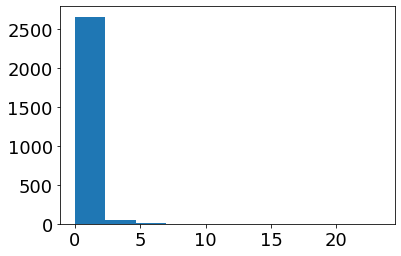

In [349]:
plt.hist(cut['duration_hr'])

In [350]:
print(cut['start station name'].unique(), cut['end station name'].unique(),cut['age_range'].unique())
print(cut['gender'].unique(), cut['age'].median())

['Broadway & W 58 St' 'Central Park S & 6 Ave' 'West Thames St'
 'Atlantic Ave & Furman St' 'Centre St & Chambers St'
 'Vesey Pl & River Terrace'] ['Broadway & W 58 St' 'Central Park S & 6 Ave' 'West Thames St'
 'Atlantic Ave & Furman St' 'Centre St & Chambers St'
 'Vesey Pl & River Terrace'] ['100+']
Categories (7, object): ['25-30' < '30-40' < '40-50' < '50-60' < '60-70' < '70-80' < '100+']
['Female']
Categories (3, object): ['Female', 'Male', 'Unknown'] nan


/usr/local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


### Most populer Subscriber Trip

In [354]:
df_subs=df_bike[df_bike['usertype']=='Subscriber'].groupby(['start station name', 'end station name']).filter(lambda x: x['tripduration'].count() >= 100)
df_subs.shape

(633, 26)

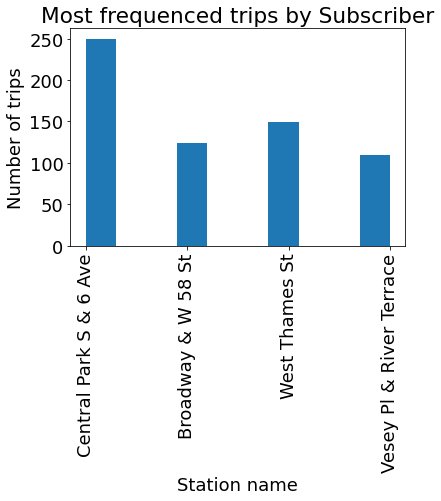

In [356]:
plt.hist(df_subs['start station name'])
plt.xticks(rotation='vertical')
#plt.xticks(rotation=45)
plt.title('Most frequenced trips by Subscriber')
plt.xlabel('Station name')
plt.ylabel('Number of trips')
plt.show()

In [352]:
print(df_subs['start station name'].unique(), df_subs['end station name'].unique(),df_subs['gender'].unique())
print(df_subs['weekday'].unique(), df_subs['age'].median())

['Central Park S & 6 Ave'] ['Central Park S & 6 Ave'] ['Male', 'Unknown']
Categories (3, object): ['Female', 'Male', 'Unknown']
['Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday'] 36.5


In [ ]:
sns.histplot(df_subs['duration_hr'])

### Geometry 
https://livecodestream.dev/post/how-to-plot-your-data-on-maps-using-python-and-folium/
https://towardsdatascience.com/visualizing-bike-mobility-in-london-using-interactive-maps-for-absolute-beginners-3b9f55ccb59    

In [ ]:
from shapely.geometry import Point, Polygon
geometry_start_st = [Point(xy) for xy in zip(df_bike['start station longitude'], df_bike['start station latitude'])]
geometry_start_st[:2]

In [ ]:
import geopandas as gpd
street_map = gpd.read_file("/Users/psaxena/Downloads/NYS_Civil_Boundaries/Counties.shp")

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')

In [ ]:
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=us_states,
    name='choropleth',
    data=df_bike,
    columns=['start station lattitude', 'age'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate %'
).add_to(m)

m

In [ ]:
gdf = geopandas.GeoDataFrame(df_bike, geometry=geopandas.points_from_xy(df_bike["start station longitude"], 
                                                                        df_bike["start station latitude"]))

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')
# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

In [ ]:
plt.hist(df_bike["start station id"].unique())

In [ ]:
plt.hist(df_bike["start station id"])
print("number of unique start-station-id is: ", df_bike["start station id"].unique().shape)

In [ ]:
sns.histplot(df_bike["end station id"].unique())
print("number of unique end-station-id is: ", df_bike["end station id"].unique().shape)

In [ ]:
sns.countplot(data=df_bike, x='start station id', order=df_bike["start station id"].value_counts().index)

In [ ]:
sns.displot(data=df_bike, x="age", hue='usertype', multiple='stack', aspect=10/5); 

In [ ]:
plt.boxplot(df_bike['duration_mins'])
print(df_bike['duration_mins'].describe())

# Modelling

## Splitting of train / val / test dataset

In [84]:
def get_class_counts(df, label, count_var):
    '''
    param df : pandas dataframe
    param label : label as string
    
    Give class counts of the label in df
    
    Eg: df = pd.DataFrame({'Team':['Riders', 'Riders', 'Riders', 'Kings','Kings'], 
                           'year':['2016','2016','2015','2018','2016']})
       get_class_counts(df, label='Team', count_var='year') will give you:
       {'Kings': 2, 'Riders': 3}  
    '''
    grp = df.groupby([label])[count_var].count()
    return {key: grp[key] for key in list(grp.keys())}


def get_class_proportions(df, label, count_var):
    '''
    param df: pandas dataframe
    param label : label as string
    
    Give proportion of the label class in df dataset. 
    
    Eg: df = pd.DataFrame({'Team':['Riders', 'Riders', 'Riders', 'Kings','Kings'], 
                           'year':['2016','2016','2015','2018','2016']})
        get_class_proportions(df, label='Team', count_var='year') will give you:
        {'Kings': 0.4, 'Riders': 0.6}
    '''
    class_counts = get_class_counts(df, label, count_var)
    return {val[0]: round(val[1]/df.shape[0],4) for val in class_counts.items()}

In [127]:
from sklearn.model_selection import train_test_split

def data_split(dataset, label, count_var, train_frac, random_state=123):
    ''' 
    param dataset  : Data to be split
    param label    : label as string
    param train_frac: Ratio of train set to whole dataset

    Randomly split dataset, based on these ratios:
        'train': train_frac
        'valid': (1-train_frac) / 2
        'test':  (1-train_frac) / 2

    Eg: passing train_frac=0.8 gives a 80% / 10% / 10% split
    '''

    assert train_frac >= 0 and train_frac <= 1, "Invalid training set fraction"

    train, tmp = train_test_split(dataset, train_size=train_frac, random_state=random_state, shuffle=True,
                                  stratify=dataset[label])
    val, test  = train_test_split(tmp, train_size=0.5, random_state=random_state, shuffle=True,
                                  stratify=tmp[label])
    
    print(f"Class proportion: \n in train: {get_class_proportions(train, label, count_var)} \n in val: {get_class_proportions(val, label, count_var)} \n in test: {get_class_proportions(test, label, count_var)}")
    return train, val, test

In [316]:
selected_columns = df_bike[['start station id', 'end station id', 'gender','weekday','age_range','hour', 'usertype']]
df_bike_model = selected_columns.copy()
df_bike_model['gender']= df_bike_model['gender'].replace(gender_str, gender_int)

df_bike_model.head(3) 

,start station id,end station id,gender,weekday,age_range,hour,usertype
0,444,434.0,1,Saturday,25-30,0,Subscriber
1,444,434.0,1,Saturday,25-30,0,Subscriber
2,406,406.0,0,Saturday,100+,0,Customer


In [317]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in df_bike_model.columns:
    if df_bike_model[column_name].dtype.name == 'category' or df_bike_model[column_name].dtype == object:
        df_bike_model[column_name] = le.fit_transform(df_bike_model[column_name])
    else:
        pass

In [318]:
print(df_bike_model.dtypes)
df_bike_model.head(2)

start station id      int64
end station id      float64
gender                int64
weekday               int64
age_range             int64
hour                  int64
usertype              int64
dtype: object


,start station id,end station id,gender,weekday,age_range,hour,usertype
0,444,434.0,1,2,1,0,1
1,444,434.0,1,2,1,0,1


In [320]:
train, val, test = data_split(df_bike_model, label='usertype', count_var='gender',train_frac=0.8)

Class proportion: 
 in train: {0: 0.416, 1: 0.584} 
 in val: {0: 0.416, 1: 0.584} 
 in test: {0: 0.416, 1: 0.584}


## Algorithm 
1. https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/

### Bagged decision Tree

In [158]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

kfold = model_selection.KFold(n_splits=10, random_state=123, shuffle=True)
cart = DecisionTreeClassifier()
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=123)
results = model_selection.cross_val_score(model, 
                                          train.loc[:, train.columns != 'usertype'],train['usertype'], 
                                          cv=kfold)
print(results.mean())

/Users/psaxena/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.9999932953902075


### RandomForst 

In [153]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

num_trees = 100
max_features = 3
kfold = model_selection.KFold(n_splits=10, random_state=123)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, train.loc[:, train.columns != 'usertype'],
                                          train['usertype'],
                                          cv=kfold)
print(results.mean(), results.std())

/Users/psaxena/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.9999932953902075 1.0241460627179565e-05


### xgBoosting

In [151]:
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

num_trees = 30
kfold = model_selection.KFold(n_splits=10, random_state=123)
model_xgboost = AdaBoostClassifier(n_estimators=num_trees, random_state=12)
results = model_selection.cross_val_score(model,train.loc[:, train.columns != 'usertype'],
                                          train['usertype'], cv=kfold)

/Users/psaxena/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


NameError: name 'mean' is not defined

In [152]:
# report performance
print('Accuracy: %.3f (%.3f)' % (results.mean(), results.std()))

Accuracy: 1.000 (0.000)


In [321]:
# fit model no training data
import xgboost

model_xg = xgboost.XGBClassifier()
model_xg.fit(train.loc[:, train.columns != 'usertype'], train['usertype'])
print(model_xg)

/Users/psaxena/Library/Python/3.8/lib/python/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:52:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [322]:
# make predictions for test data
y_pred = model_xg.predict(val.loc[:, val.columns != 'usertype'])
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(val['usertype'], predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


### Ensemble

In [ ]:
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)
print(results.mean())

## modelling:
https://www.kaggle.com/carolineecc/xg-boost-random-forest-ridge-lasso-regression

# Accident dataset

## Upload Dataset

In [ ]:
df_ins = pd.read_csv(os.path.join(path_dataset, os.listdir(path_dataset)[0]))
print(f"shape of insurance dataset is {df_ins.shape}")
df_ins.head()

## Insight into data

In [ ]:
draw_stats(df_ins, n_rows=11, n_cols=2)

In [ ]:
df_ins.describe()

In [ ]:
df_ins.isnull().sum()

## Feature Enginurring

In [ ]:
list_for_boxplot=["NUMBER OF MOTORIST INJURED", "NUMBER OF MOTORIST KILLED", "NUMBER OF PERSONS INJURED", 
                  "NUMBER OF PERSONS KILLED", "NUMBER OF PEDESTRIANS INJURED","NUMBER OF PEDESTRIANS KILLED"]
sns.boxplot(x='variable', y='value', data=pd.melt(df_ins[list_for_boxplot]))

In [ ]:
df_ins['BOROUGH'] = df_ins.BOROUGH.astype('category')
df_ins["BOROUGH"].value_counts().plot(kind='bar')